In [1]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv

# Ladda miljövariabler från .env
load_dotenv()

# Hämta klientuppgifter
CLIENT_ID = os.getenv("STRAVA_CLIENT_ID")
CLIENT_SECRET = os.getenv("STRAVA_CLIENT_SECRET")
REDIRECT_URI = os.getenv("STRAVA_REDIRECT_URI")

print("✅ Miljövariabler laddade.")

✅ Miljövariabler laddade.


In [2]:
# Ladda befintliga tokens från .env
load_dotenv(override=True)  # VIKTIGT: override=True

ACCESS_TOKEN = os.getenv("STRAVA_ACCESS_TOKEN")
REFRESH_TOKEN = os.getenv("STRAVA_REFRESH_TOKEN")

if not ACCESS_TOKEN or not REFRESH_TOKEN:
    print("❌ ACCESS_TOKEN eller REFRESH_TOKEN saknas i .env!")
    print("Du måste köra Cell 2 och Cell 3 för att få tokens första gången.")
else:
    print("✅ Tokens laddade från .env")
    print(f"ACCESS_TOKEN: {ACCESS_TOKEN[:20]}...")
    print(f"REFRESH_TOKEN: {REFRESH_TOKEN[:20]}...")

✅ Tokens laddade från .env
ACCESS_TOKEN: 0ff3437cef2ab84b6378...
REFRESH_TOKEN: 769acc4abb7d0fd81af0...


In [ ]:
# Skapa OAuth URL - OBS KÖRS HELST BARA EN GÅNG!
oauth_url = (
    f"https://www.strava.com/oauth/authorize?"
    f"client_id={CLIENT_ID}&"
    f"response_type=code&"
    f"redirect_uri={REDIRECT_URI}&"
    f"approval_prompt=auto&"
    f"scope=activity:read_all"
)

print("👉 Öppna denna länk i din webbläsare och godkänn åtkomst:")
print(oauth_url)

In [ ]:
# OBS KÖRS HELST BARA EN GÅNG!
# Klistra in koden du fick från omdirigeringen här
AUTHORIZATION_CODE = "7132ef90d982269d082ee6922e5b8fa885cae521"
# Byt code mot tokens
token_url = "https://www.strava.com/oauth/token"
payload = {
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "code": AUTHORIZATION_CODE,
    "grant_type": "authorization_code"
}

response = requests.post(token_url, data=payload)

if response.status_code == 200:
    token_data = response.json()
    ACCESS_TOKEN = token_data["access_token"]
    REFRESH_TOKEN = token_data["refresh_token"]

    # Spara tokens i .env
    with open(".env", "a") as f:
        f.write(f"\nSTRAVA_ACCESS_TOKEN={ACCESS_TOKEN}")
        f.write(f"\nSTRAVA_REFRESH_TOKEN={REFRESH_TOKEN}")

    print("✅ Tokens hämtade och sparade i .env")
else:
    print("❌ Fel vid tokenhämtning:", response.text)

In [3]:
def refresh_access_token():
    global ACCESS_TOKEN, REFRESH_TOKEN

    url = "https://www.strava.com/oauth/token"
    payload = {
        "client_id": CLIENT_ID,
        "client_secret": CLIENT_SECRET,
        "grant_type": "refresh_token",
        "refresh_token": REFRESH_TOKEN
    }

    response = requests.post(url, data=payload)

    if response.status_code == 200:
        data = response.json()
        ACCESS_TOKEN = data["access_token"]
        REFRESH_TOKEN = data["refresh_token"]

        # Uppdatera .env-filen
        with open(".env", "r") as f:
            lines = f.readlines()
        with open(".env", "w") as f:
            for line in lines:
                if line.startswith("STRAVA_ACCESS_TOKEN="):
                    f.write(f"STRAVA_ACCESS_TOKEN={ACCESS_TOKEN}\n")
                elif line.startswith("STRAVA_REFRESH_TOKEN="):
                    f.write(f"STRAVA_REFRESH_TOKEN={REFRESH_TOKEN}\n")
                else:
                    f.write(line)

        print("✅ Token förnyad och .env uppdaterad")
    else:
        print("❌ Fel vid tokenförnyelse:", response.text)

In [4]:
def get_strava_activities():
    url = "https://www.strava.com/api/v3/athlete/activities"
    headers = {"Authorization": f"Bearer {ACCESS_TOKEN}"}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print("❌ Fel vid hämtning av aktiviteter:", response.text)
        return []

# Förnya token innan du hämtar data
refresh_access_token()

# Hämta data
activities = get_strava_activities()

✅ Token förnyad och .env uppdaterad


,name,type,distance_km,moving_time_h,start_date_local
0,Lunch Run,Run,0.0000,0.001111,2025-12-16T12:23:37Z
1,Morning Run,Run,5.9999,0.546111,2025-12-15T07:00:08Z
2,Afternoon Run,Run,5.0720,0.494167,2025-12-11T15:39:22Z
3,Morning Run,Run,5.0048,0.456944,2025-12-08T06:13:36Z
4,Morning Run,Run,4.0076,0.355833,2025-12-07T09:29:17Z


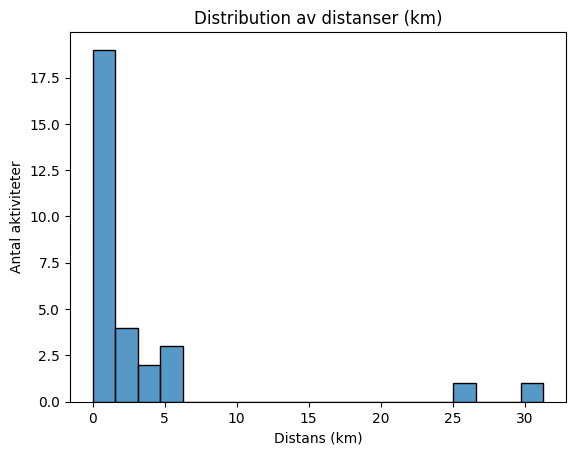

In [5]:
# Konvertera till DataFrame
df = pd.DataFrame(activities)

# Enkel bearbetning
df['distance_km'] = df['distance'] / 1000
df['moving_time_h'] = df['moving_time'] / 3600

# Visa första raderna
display(df[['name', 'type', 'distance_km', 'moving_time_h', 'start_date_local']].head())

# Plotta distansfördelning
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['distance_km'], bins=20)
plt.title("Distribution av distanser (km)")
plt.xlabel("Distans (km)")
plt.ylabel("Antal aktiviteter")
plt.show()

In [ ]:
from stravalib.client import Client
import datetime
from dotenv import load_dotenv
import os
import pytz  # för tidszonshantering

load_dotenv()
client = Client()

access_token = os.getenv('STRAVA_ACCESS_TOKEN')
if not access_token:
    raise ValueError("STRAVA_ACCESS_TOKEN saknas i miljövariablerna")

client.access_token = access_token

# Använd UTC timezone för after och before
utc = pytz.UTC
after = utc.localize(datetime.datetime(2025, 12, 1))
before = utc.localize(datetime.datetime.now())

# Hämtar aktiviteter med paginering
activities = client.get_activities(after=after, before=before)

count = 0
for activity in activities:
    print(activity.name, activity.start_date, activity.distance, activity.average_heartrate, activity.max_heartrate)
    count += 1

if count == 0:
    print("Inga aktiviteter hittades i det angivna datumintervallet.")

In [7]:
# import pandas as pd
# df= pd.DataFrame([activity.__dict__ for activity in activities])

df

,resource_state,athlete,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,...,upload_id,upload_id_str,external_id,from_accepted_tag,pr_count,total_photo_count,has_kudoed,suffer_score,distance_km,moving_time_h
0,2,"{'id': 86820299, 'resource_state': 1}",Lunch Run,0.0,4,4,0.0,Run,Run,None,...,17847311513,17847311513,garmin_ping_513186001673,False,0,0,False,0.0,0.0000,0.001111
1,2,"{'id': 86820299, 'resource_state': 1}",Morning Run,5999.9,1966,2189,45.2,Run,Run,None,...,17847419338,17847419338,activity_21260470163.tcx,False,0,0,False,57.0,5.9999,0.546111
2,2,"{'id': 86820299, 'resource_state': 1}",Afternoon Run,5072.0,1779,1822,51.0,Run,Run,None,...,17847419330,17847419330,activity_21229930933.tcx,False,2,0,False,44.0,5.0720,0.494167
3,2,"{'id': 86820299, 'resource_state': 1}",Morning Run,5004.8,1645,1645,30.1,Run,Run,None,...,17847419325,17847419325,activity_21198492489.tcx,False,0,0,False,54.0,5.0048,0.456944
4,2,"{'id': 86820299, 'resource_state': 1}",Morning Run,4007.6,1281,1281,25.9,Run,Run,None,...,17847419317,17847419317,activity_21190441741.tcx,False,0,0,False,37.0,4.0076,0.355833
5,2,"{'id': 86820299, 'resource_state': 1}",Afternoon Ride,0.0,3603,3603,0.0,Ride,Ride,None,...,17847419311,17847419311,activity_21169085743.tcx,False,0,0,False,129.0,0.0000,1.000833
6,2,"{'id': 86820299, 'resource_state': 1}",Morning Run,4014.1,1297,1572,26.1,Run,Run,None,...,17847419302,17847419302,activity_21136685412.tcx,False,0,0,False,35.0,4.0141,0.360278
7,2,"{'id': 86820299, 'resource_state': 1}",Morning Run,3004.8,1029,1029,16.0,Run,Run,None,...,17847419300,17847419300,activity_21128153576.tcx,False,0,0,False,20.0,3.0048,0.285833
8,2,"{'id': 86820299, 'resource_state': 1}",Morning Ride,0.0,2705,2705,0.0,Ride,Ride,None,...,17847419292,17847419292,activity_21102458470.tcx,False,0,0,False,107.0,0.0000,0.751389
9,2,"{'id': 86820299, 'resource_state': 1}",Afternoon Ride,0.0,7625,7625,0.0,Ride,Ride,None,...,17847419284,17847419284,activity_21078990315.tcx,False,0,0,False,115.0,0.0000,2.118056


In [8]:
df.columns

Index(['resource_state', 'athlete', 'name', 'distance', 'moving_time',
       'elapsed_time', 'total_elevation_gain', 'type', 'sport_type',
       'workout_type', 'device_name', 'id', 'start_date', 'start_date_local',
       'timezone', 'utc_offset', 'location_city', 'location_state',
       'location_country', 'achievement_count', 'kudos_count', 'comment_count',
       'athlete_count', 'photo_count', 'map', 'trainer', 'commute', 'manual',
       'private', 'visibility', 'flagged', 'gear_id', 'start_latlng',
       'end_latlng', 'average_speed', 'max_speed', 'has_heartrate',
       'average_heartrate', 'max_heartrate', 'heartrate_opt_out',
       'display_hide_heartrate_option', 'elev_high', 'elev_low', 'upload_id',
       'upload_id_str', 'external_id', 'from_accepted_tag', 'pr_count',
       'total_photo_count', 'has_kudoed', 'suffer_score', 'distance_km',
       'moving_time_h'],
      dtype='object')

In [9]:
df[['elapsed_time','distance','average_speed','max_speed', 'elapsed_time', 'moving_time']]

,elapsed_time,distance,average_speed,max_speed,elapsed_time,moving_time
0,4,0.0,0.000,0.000,4,4
1,2189,5999.9,3.052,3.929,2189,1966
2,1822,5072.0,2.851,3.980,1822,1779
3,1645,5004.8,3.042,3.900,1645,1645
4,1281,4007.6,3.128,3.950,1281,1281
5,3603,0.0,0.000,0.000,3603,3603
6,1572,4014.1,3.095,3.743,1572,1297
7,1029,3004.8,2.920,3.692,1029,1029
8,2705,0.0,0.000,0.000,2705,2705
9,7625,0.0,0.000,0.000,7625,7625


In [ ]:
df['elapsed_time'] = df['elapsed_time'] /60 # minutes
df['elapsed_time']

In [ ]:
df['distance'] = df['distance'] / 1000 # km
df['distance']

In [ ]:
df['moving_time'] = df['moving_time'] /60 # minutes
df['moving_time']

In [ ]:
df[['average_speed', 'max_speed']] = df[['average_speed', 'max_speed']] # *60(gör om meter per sekund till meter per minut)

In [ ]:
df['max_heartrate'] = ((df['max_heartrate']

In [ ]:
df['max_heartrate']